In [ ]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchsummary import summary

use the GPU if avaliable, otherwise use the CPU

In [ ]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
device

'cpu'

# Load Dataset

In [ ]:
dataset = datasets.FashionMNIST(
    root = 'data',
    train = True,
    transform = transforms.ToTensor(),
    download = True
)

100%|██████████| 26421880/26421880 [00:01<00:00, 18937710.20it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 347934.88it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 6351968.52it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 11328581.84it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



80% training set, 10% validation set, 10% testing set

In [ ]:
train_dataset, val_dataset, test_dataset = random_split(dataset, [0.8,0.1,0.1])

In [ ]:
BATCH_SIZE = 200

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Model

In [ ]:
# most frequent class classifier
# always returns the label is encounted the most
class BaselineClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.w = torch.zeros(10, requires_grad=False)
    def forward(self, y):
        if self.training:
            for y_i in y:
                self.w[y_i.item()] += 1
        return self.w

In [ ]:
# https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
class NormalConv(nn.Module):
    def __init__(self, out_channels, kernel_size, stride=1, padding=0):
        super().__init__()
        self.layers = nn.Sequential(
            nn.LazyConv2d(out_channels, kernel_size, stride, padding, bias=False),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
        )
        self.to(device)
    def forward(self, x):
        return self.layers(x)

class CatConv(nn.Module):
    def __init__(self, k):
        super().__init__()
        # new_size = (old_size - kernel_size + 2 * padding)/stride + 1
        #          = (old_size - 3 + 2 * 1)/1 + 1
        #          = (old_size - 1) + 1
        # no change in 1st or 2nd dimension
        self.layer = NormalConv(k, kernel_size=3, padding=1)
        self.to(device)
    def forward(self, x):
        logits = self.layer(x)
        return torch.cat([x, logits], dim=1)

class ImageClassifier(nn.Module):
    # NormConv(out_channels, kernel_size, stride, padding)
    #   changes size of 2nd and 1st dimensions
    #   new_size = (old_size - kernel_size + 2 * padding)/stride + 1
    # CatConv(k):
    #   increases size of 3rd dimension by k
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            # Gets an image of size 1x28x28
            CatConv(k=4), # 5x28x28
            CatConv(k=5), # 10x28x28
            CatConv(k=5), # 15x28x28
            CatConv(k=5), # 20x28x28
            NormalConv(out_channels=5, kernel_size=6, stride=2, padding=0), # 3x12x12
            CatConv(k=5), # 10x12x12
            CatConv(k=5), # 15x12x12
            CatConv(k=5), # 20x12x12
            CatConv(k=5), # 25x12x12
            NormalConv(out_channels=10, kernel_size=6, stride=2, padding=0), # 10x4x4
            nn.Flatten(), # 10*4*4
            nn.LazyLinear(out_features=10), # 10 classes
        )
        self.to(device)

    def forward(self, x):
        return self.layers(x)

# Train/Eval

In [ ]:
def run_baseline(model: BaselineClassifier, dataloader: DataLoader):
    num_correct = 0
    for x, y in dataloader:
        # forward pass
        logits = model.forward(y)
        pred_y = logits.argmax(dim=0)
        # calculate score
        num_correct += sum(pred_y == y).item()
    accuracy = 100*(num_correct/len(dataloader.dataset))
    return accuracy

In [ ]:
def train_model(model: nn.Module, dataloader: DataLoader, loss_fn: nn.Module, optimizer: optim.Optimizer):
    num_correct = 0
    for x, y in dataloader:
        # move data to GPU (if avaliable)
        x = x.to(device)
        y = y.to(device)
        # forward pass
        logits = model.forward(x)
        pred_y = logits.argmax(dim=1)
        # calculate gradients
        loss = loss_fn(logits, y)
        loss.backward()
        # backward pass
        optimizer.step()
        optimizer.zero_grad()
        # calculate score
        num_correct += sum(pred_y == y).item()
    accuracy = 100*(num_correct/len(dataloader.dataset))
    return accuracy

def eval_model(model: nn.Module, dataloader: DataLoader):
    num_correct = 0
    with torch.no_grad():
        for x, y in dataloader:
            # move data to GPU (if avaliable)
            x = x.to(device)
            y = y.to(device)
            # forward pass
            logits = model.forward(x)
            pred_y = logits.argmax(dim=1)
            # calculate score
            num_correct += sum(pred_y == y).item()
    accuracy = 100*(num_correct/len(dataloader.dataset))
    return accuracy

In [ ]:
from tqdm.notebook import tqdm

# TRAIN/EVAL BASELINE
train_results_baseline = []
eval_results_baseline = []

baseline_model = BaselineClassifier()
for epoch in tqdm(range(20)):
    baseline_model.train()
    train_results_baseline.append( run_baseline(baseline_model, train_dataloader) )
    baseline_model.eval()
    eval_results_baseline.append( run_baseline(baseline_model, val_dataloader) )

# TRAIN/EVAL MODEL
train_results = []
eval_results = []

model = ImageClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
for epoch in tqdm(range(20)):
    model.train()
    train_results.append( train_model(model, train_dataloader, criterion, optimizer) )
    model.eval()
    eval_results.append( eval_model(model, val_dataloader) )

  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/20 [00:00<?, ?it/s]

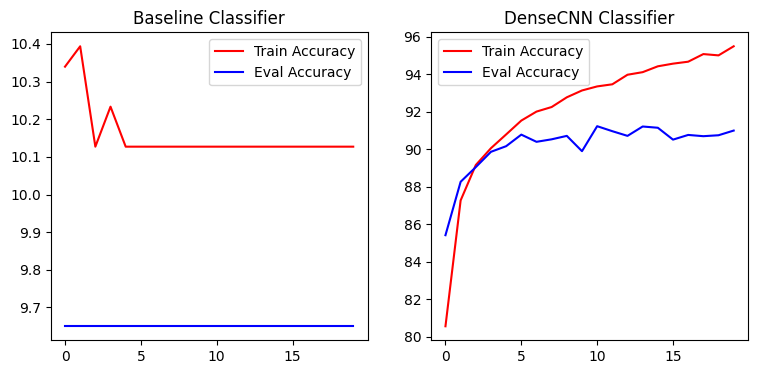

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,4))
ax = plt.subplot(1, 2, 1)
ax.set_title('Baseline Classifier')
ax.plot(train_results_baseline, label='Train Accuracy', color='red')
ax.plot(eval_results_baseline, label='Eval Accuracy', color='blue')
ax.legend()
ax = plt.subplot(1, 2, 2)
ax.set_title('DenseCNN Classifier')
ax.plot(train_results, label='Train Accuracy', color='red')
ax.plot(eval_results, label='Eval Accuracy', color='blue')
ax.legend()
plt.show()

In [ ]:
eval_model(model, test_dataloader)

90.83333333333333

In [ ]:
results_train